In [1]:
import time, numpy as np, matplotlib.pyplot as plt
# PyTorch
import torch
from torch.nn.utils import parameters_to_vector, vector_to_parameters

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import models

model = models.Net()

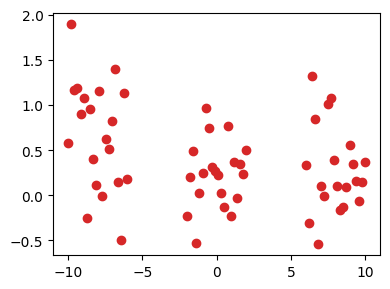

In [3]:
def featurize(x):
    return torch.cat([x[:, None], x[:, None]**2], dim=1)

x = torch.cat([torch.linspace(start=-10, end=-6, steps=20, dtype=torch.float),
               torch.linspace(start= -2, end= 2, steps=20, dtype=torch.float),
               torch.linspace(start=  6, end=10, steps=20, dtype=torch.float)])
f = featurize(x)
y = model(f).detach() + torch.randn(60,1)*0.5

ncols, nrows = 1, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*nrows))
axs.scatter(x, y, color='#D62728')
fig.tight_layout()
plt.show()

In [4]:
def mse_loss(y_hat, y):
    return torch.mean((y - y_hat) ** 2)

def l2_penalty(params):
    return (1/2) * torch.sum(params ** 2)

In [5]:
weight_decay = 1e-2
model = models.Net()
init = parameters_to_vector(model.parameters()).detach().numpy()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [6]:
start = time.time()
from_scratch_grads = []
for epoch in range(1_000):
    optimizer.zero_grad()
    y_hat = model(f)
    nll = mse_loss(y_hat, y)
    loss = nll + weight_decay * l2_penalty(parameters_to_vector(model.parameters()))
    loss.backward()
    optimizer.step()
    if epoch < 5:
        print(f'Epoch: {epoch}, NLL: {nll.item()}')
        grads = torch.cat([param.grad.view(-1) for param in model.parameters()])
        from_scratch_grads.append(grads.detach().numpy())

linspace = torch.linspace(start=-10, end=10, steps=100, dtype=torch.float)
from_scratch_preds = model(featurize(linspace))
end = time.time()
print(f'Elapsed time: {end - start}')

Epoch: 0, NLL: 0.3811188042163849
Epoch: 1, NLL: 0.30546119809150696
Epoch: 2, NLL: 0.2955181300640106
Epoch: 3, NLL: 0.2890429198741913
Epoch: 4, NLL: 0.287745863199234
Elapsed time: 0.9011452198028564


In [7]:
model = models.Net()
vector_to_parameters(torch.tensor(init), model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=weight_decay)

In [8]:
start = time.time()
pytorch_grads = []
for epoch in range(1_000):
    optimizer.zero_grad()
    y_hat = model(f)
    nll = mse_loss(y_hat, y) 
    nll.backward()
    optimizer.step()
    if epoch < 5:
        print(f'Epoch: {epoch}, NLL: {nll.item()}')
        grads = torch.cat([param.grad.view(-1) for param in model.parameters()])
        pytorch_grads.append(grads.detach().numpy())

pytorch_preds = model(featurize(linspace))
end = time.time()
print(f'Elapsed time: {end - start}')

Epoch: 0, NLL: 0.3811188042163849
Epoch: 1, NLL: 0.30546119809150696
Epoch: 2, NLL: 0.2955181300640106
Epoch: 3, NLL: 0.2890429198741913
Epoch: 4, NLL: 0.287745863199234
Elapsed time: 0.6379377841949463


In [9]:
for from_scratch_grad, pytorch_grad in zip(from_scratch_grads, pytorch_grads):
    print(np.linalg.norm(from_scratch_grad - pytorch_grad))

0.03527531
0.035233155
0.03523781
0.035236932
0.035243087


In [10]:
model = models.Net()
vector_to_parameters(torch.tensor(init), model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
prior = torch.distributions.normal.Normal(0, np.sqrt(1/(len(y)*weight_decay)))

In [11]:
start = time.time()
bayesian_grads = []
for epoch in range(1_000):
    optimizer.zero_grad()
    y_hat = model(f)
    nll = mse_loss(y_hat, y) 
    loss = nll - (1/len(y)) * torch.sum(prior.log_prob(parameters_to_vector(model.parameters())))
    loss.backward()
    optimizer.step()
    if epoch < 5:
        print(f'Epoch: {epoch}, NLL: {nll.item()}')
        grads = torch.cat([param.grad.view(-1) for param in model.parameters()])
        bayesian_grads.append(grads.detach().numpy())

bayesian_preds = model(featurize(linspace))
end = time.time()
print(f'Elapsed time: {end - start}')

Epoch: 0, NLL: 0.3811188042163849
Epoch: 1, NLL: 0.30546119809150696
Epoch: 2, NLL: 0.2955181300640106
Epoch: 3, NLL: 0.2890429198741913
Epoch: 4, NLL: 0.287745863199234
Elapsed time: 1.003232717514038


In [12]:
for bayesian_grad, pytorch_grad in zip(bayesian_grads, pytorch_grads):
    print(np.linalg.norm(bayesian_grad - pytorch_grad))

0.035275325
0.035233162
0.03523782
0.03523694
0.035243094


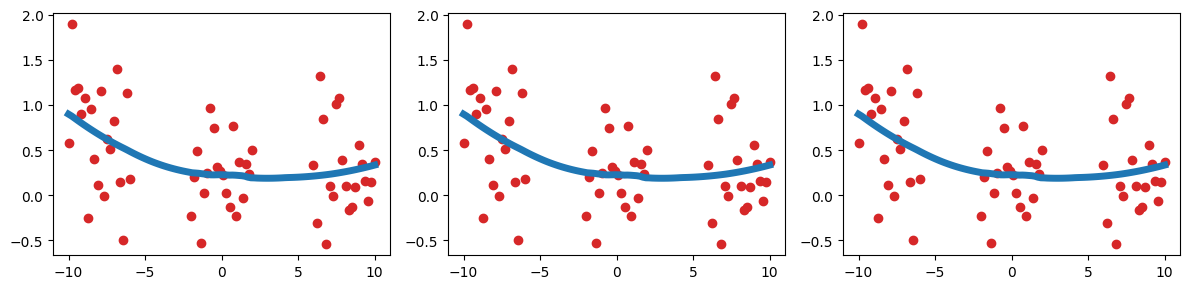

In [13]:
ncols, nrows = 3, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*nrows))
axs[0].scatter(x, y, color='#D62728')
axs[0].plot(linspace.data.numpy(), from_scratch_preds.data.numpy(), color='#1F77B4', lw=5)
axs[1].scatter(x, y, color='#D62728')
axs[1].plot(linspace.data.numpy(), pytorch_preds.data.numpy(), color='#1F77B4', lw=5)
axs[2].scatter(x, y, color='#D62728')
axs[2].plot(linspace.data.numpy(), bayesian_preds.data.numpy(), color='#1F77B4', lw=5)
fig.tight_layout()
plt.show()